# **1. Setup Environment**

In [ ]:
# Install TensorFlow.js library
!pip install --upgrade tensorflowjs

  Using cached tensorflowjs-4.20.0-py3-none-any.whl (89 kB)
  Using cached tensorflow_decision_forests-1.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.5 MB)
  Using cached packaging-23.2-py3-none-any.whl (53 kB)
  Using cached wurlitzer-3.1.1-py3-none-any.whl (8.6 kB)
  Using cached tf_keras-2.16.0-py3-none-any.whl (1.7 MB)
  Using cached ydf-0.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.3 MB)
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.15.1
    Uninstalling tf_keras-2.15.1:
      Successfully uninstalled tf_keras-2.15.1


In [ ]:
# Install Kaggle API client library
!pip install kaggle

# Install TensorFlow Datasets library
!pip install tensorflow-datasets

# Install Roboflow client library
!pip install roboflow

In [ ]:
# Install Keras Tuner library
!pip install keras-tuner

# Import necessary libraries

In [ ]:
# Libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Libraries for building and training neural network models
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import RandomSearch

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2, InceptionV3, EfficientNetB0, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

# Libraries for handling file operations
import os
import keras
import time
import shutil
import random
import itertools
from PIL import Image
from google.colab import files  # Specific to Google Colab environment


# **2. Download Data from Kaggle and Roboflow**

## Download Data from Kaggle API

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marlinausman","key":"c580101b6db6a5fd93d8ebd7e752f620"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kondwani/eye-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/kondwani/eye-disease-dataset
License(s): CC-BY-NC-SA-4.0
 60% 3.00M/4.96M [00:00<00:00, 5.49MB/s]
100% 4.96M/4.96M [00:00<00:00, 7.05MB/s]


In [ ]:
!unzip /content/eye-disease-dataset.zip

Archive:  /content/eye-disease-dataset.zip
  inflating: Eye_diseases/Bulging_Eyes/image-10.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/image-11.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/image-12.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/image-13.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/image-14.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/image-15.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/image-2.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/image-3.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/image-4.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/image-5.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/image-6.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/image-7.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/image-8.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/image-9.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/image.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/images-10.jpeg  
  inflating: Eye_diseases/Bulging_Eyes/images-11.jpeg  
  inflating: Eye_diseases/Bulgi

# Download Roboflow dataset

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="vAFw3T9ViJqfv7xM0R8I")
project = rf.workspace("muhammad-risma-nqgw8").project("eye-diseases-7shia")
version = project.version(7)
dataset = version.download("tensorflow")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Eye-Diseases-7 in tensorflow:: 100%|██████████| 481/481 [00:00<00:00, 3706.61it/s]


## **3. Load and Combine Datasets**

In [ ]:
!unzip /content/Combined_Eye_Diseases.zip

unzip:  cannot find or open /content/Combined_Eye_Diseases.zip, /content/Combined_Eye_Diseases.zip.zip or /content/Combined_Eye_Diseases.zip.ZIP.


In [ ]:
# Path to the dataset
kaggle_dataset_path = '/content/Eye_diseases'
roboflow_dataset_path = '/content/Eye-Diseases-7'
combined_dataset_path = '/content/Combined_Eye_Diseases'

# Create a directory for the combined dataset
os.makedirs(combined_dataset_path, exist_ok=True)

# Define classes for both datasets
classes = ['Bulging_Eyes', 'Cataracts', 'Crossed_Eyes', 'Glaucoma', 'Normal_eyes', 'Uveitis']

# Create subdirectories for each class in the combined dataset
for class_name in classes:
    combined_class_path = os.path.join(combined_dataset_path, class_name)
    os.makedirs(combined_class_path, exist_ok=True)

### Copy images from Roboflow dataset

In [ ]:
# Copy images from the Roboflow dataset to the combined directory
for split in ['train', 'valid', 'test']:
    annotation_file = os.path.join(roboflow_dataset_path, split, '_annotations.csv')
    if os.path.exists(annotation_file):
        roboflow_annotations = pd.read_csv(annotation_file)
        for _, row in roboflow_annotations.iterrows():
            class_name = row['class']
            filename = row['filename']
            src_file = os.path.join(roboflow_dataset_path, split, filename)
            dst_file = os.path.join(combined_dataset_path, class_name, filename)

            # Create the destination directory if it doesn't exist
            os.makedirs(os.path.dirname(dst_file), exist_ok=True)

            # Copy Files
            shutil.copy(src_file, dst_file)


### Copy images from Kaggle dataset

In [ ]:
# Copy images from the Kaggle dataset to the combined directory
for class_name in classes:
    kaggle_class_path = os.path.join(kaggle_dataset_path, class_name)
    combined_class_path = os.path.join(combined_dataset_path, class_name)

    if os.path.exists(kaggle_class_path):
        for file_name in os.listdir(kaggle_class_path):
            src_file = os.path.join(kaggle_class_path, file_name)
            dst_file = os.path.join(combined_class_path, file_name)

            # Create the destination directory if it doesn't exist
            os.makedirs(os.path.dirname(dst_file), exist_ok=True)

            # Copy Files
            shutil.copy(src_file, dst_file)

### Verify the combined dataset

In [ ]:
# Verify the number of images in each class
for class_name in classes:
    combined_class_path = os.path.join(combined_dataset_path, class_name)
    if os.path.exists(combined_class_path):
        print(f"{class_name} (combined): {len(os.listdir(combined_class_path))} images")
    else:
        print(f"Directory for {class_name} does not exist.")

Bulging_Eyes (combined): 30 images
Cataracts (combined): 99 images
Crossed_Eyes (combined): 287 images
Glaucoma (combined): 82 images
Normal_eyes (combined): 280 images
Uveitis (combined): 101 images


### Save combined dataset as a ZIP file

In [ ]:
# Compress the Combined_Eye_Diseases directory into a ZIP file
shutil.make_archive('/content/Combined_Eye_Diseases', 'zip', '/content/Combined_Eye_Diseases')

# Download file ZIP
from google.colab import files
files.download('/content/Combined_Eye_Diseases.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **4. Display Sample Images**

In [ ]:
def show_sample_images(dataset_path, classes, num_images=5):
    plt.figure(figsize=(20, 10))

    for idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        images = os.listdir(class_path)[:num_images]

        for i, image_name in enumerate(images):
            img_path = os.path.join(class_path, image_name)
            img = Image.open(img_path)
            ax = plt.subplot(len(classes), num_images, idx * num_images + i + 1)
            plt.imshow(img)
            plt.title(f"{class_name}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


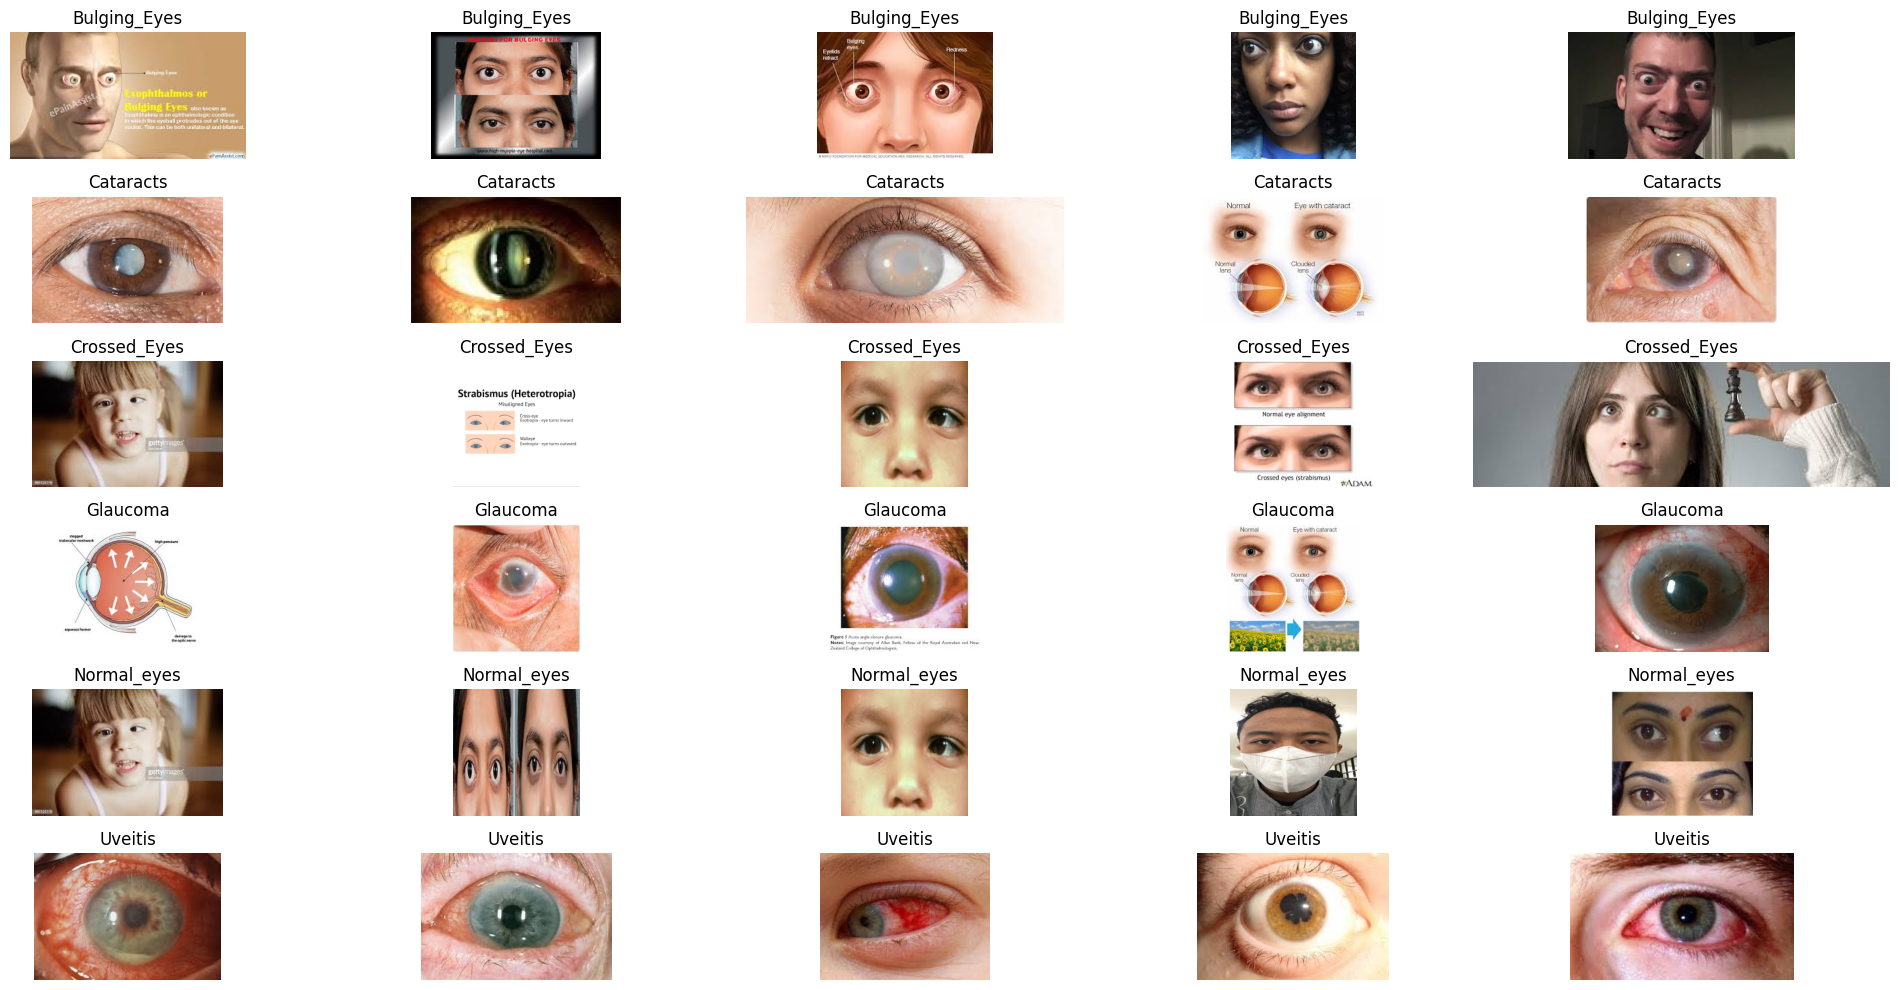

In [ ]:
from PIL import Image

combined_dataset_path = '/content/Combined_Eye_Diseases'
classes = ['Bulging_Eyes', 'Cataracts', 'Crossed_Eyes', 'Glaucoma', 'Normal_eyes', 'Uveitis']

show_sample_images(combined_dataset_path, classes, num_images=5)


# **5. Splitting Data**

#### Set up environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Specify Directories for Storing Combined Dataset and Model Outputs
combined_dataset_path = '/content/Combined_Eye_Diseases'
results_dir = '/content/drive/MyDrive/Eye_Disease_Results'  # Update According to Your Google Drive Location

# Create Directory if Not Exist
import os
if not os.path.exists(results_dir):
    os.makedirs(results_dir)


Mounted at /content/drive


### Load combined dataset

In [ ]:
# Path to Combined Dataset
combined_dataset_path = '/content/drive/MyDrive/Combined_Eye_Diseases'
train_dir = os.path.join(combined_dataset_path, 'train')
valid_dir = os.path.join(combined_dataset_path, 'valid')
test_dir = os.path.join(combined_dataset_path, 'test')

### Split data

In [ ]:
# Creating Directories for Training, Validation, and Testing Sets
for directory in [train_dir, valid_dir, test_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Class list
classes = ['Bulging_Eyes', 'Cataracts', 'Crossed_Eyes', 'Glaucoma', 'Normal_eyes', 'Uveitis']

### Divide the dataset into 70% for training, 20% for valid, and 10% for test

In [ ]:
# Function to divide the dataset
def split_dataset(class_name, src_dir, train_dir, valid_dir, test_dir, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):
    class_path = os.path.join(src_dir, class_name)
    images = os.listdir(class_path)

    train_size = int(len(images) * train_ratio)
    valid_size = int(len(images) * valid_ratio)

    train_images, test_images = train_test_split(images, test_size=test_ratio, random_state=42)
    train_images, valid_images = train_test_split(train_images, test_size=valid_size/(train_size + valid_size), random_state=42)

    for image_name in train_images:
        src_file = os.path.join(class_path, image_name)
        dst_file = os.path.join(train_dir, class_name, image_name)
        if not os.path.exists(os.path.join(train_dir, class_name)):
            os.makedirs(os.path.join(train_dir, class_name))
        shutil.copy(src_file, dst_file)

    for image_name in valid_images:
        src_file = os.path.join(class_path, image_name)
        dst_file = os.path.join(valid_dir, class_name, image_name)
        if not os.path.exists(os.path.join(valid_dir, class_name)):
            os.makedirs(os.path.join(valid_dir, class_name))
        shutil.copy(src_file, dst_file)

    for image_name in test_images:
        src_file = os.path.join(class_path, image_name)
        dst_file = os.path.join(test_dir, class_name, image_name)
        if not os.path.exists(os.path.join(test_dir, class_name)):
            os.makedirs(os.path.join(test_dir, class_name))
        shutil.copy(src_file, dst_file)

# Split the dataset for each class
for class_name in classes:
    split_dataset(class_name, combined_dataset_path, train_dir, valid_dir, test_dir)

### Verify data sharing results

In [ ]:
# Function to count the number of images in a directory
def count_images(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

print(f"Training set: {count_images(train_dir)} images")
print(f"Validation set: {count_images(valid_dir)} images")
print(f"Test set: {count_images(test_dir)} images")


Training set: 926 images
Validation set: 318 images
Test set: 169 images


# **6. Data Preprocessing and Augmentation**

In [ ]:
# Define the seed, batch size, and image size
seed = 0
batch_size = 1
img_size = (224, 224)

# Define the augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    fill_mode='nearest',
    rescale=1./255  # Ensure you rescale the images
)

# Apply the augmentation to the training data generator
train_data = datagen.flow_from_directory(
    train_dir,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=True,
    seed=seed
)

# For validation and test data, use a generator without augmentation but with rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)
val_data = validation_datagen.flow_from_directory(
    valid_dir,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=False
)

test_data = validation_datagen.flow_from_directory(
    test_dir,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=False
)

Found 925 images belonging to 6 classes.
Found 318 images belonging to 6 classes.
Found 169 images belonging to 6 classes.


# **7. Model Building with Transfer Learning**

In [ ]:
# Import necessary libraries and load InceptionV3 base model
from tensorflow.keras.applications import InceptionV3

# Load InceptionV3 model with pre-trained ImageNet weights
base_model= InceptionV3(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Define the model architecture
model = Sequential([
    Input(shape=img_size + (3,), name='input_layer'),
    base_model,
    GlobalAveragePooling2D(),  # Flatten the output of the base model
    Dense(512, activation='relu'),
    Dropout(0.4, seed=seed),
    Dense(256, activation='relu'),
    Dropout(0.4, seed=seed),
    Dense(len(set(train_data.classes)), activation='softmax', name='output_layer')
])

# Compile the model
model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = CategoricalCrossentropy(), metrics = ['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,984,742 (87.68 MB)

 Trainable params: 1,181,958 (4.51 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

# **8. Training Model**

In [ ]:
# Initialize EarlyStopping callback
model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, restore_best_weights = True)

# Initialize ReduceLROnPlateau callback
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, mode = 'min', patience=3, min_lr=0.00001)

# Train the model
history = model.fit(train_data, validation_data = val_data,
                    epochs = 100)

Epoch 1/100


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


925/925 ━━━━━━━━━━━━━━━━━━━━ 133s 119ms/step - accuracy: 0.2446 - loss: 2.0326 - val_accuracy: 0.5503 - val_loss: 1.2342
Epoch 2/100
925/925 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.4664 - loss: 1.4336 - val_accuracy: 0.5503 - val_loss: 1.1709
Epoch 3/100
925/925 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - accuracy: 0.4995 - loss: 1.3137 - val_accuracy: 0.6384 - val_loss: 0.9863
Epoch 4/100
925/925 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.5671 - loss: 1.1505 - val_accuracy: 0.6887 - val_loss: 0.8889
Epoch 5/100
925/925 ━━━━━━━━━━━━━━━━━━━━ 33s 35ms/step - accuracy: 0.5761 - loss: 1.1143 - val_accuracy: 0.6792 - val_loss: 0.9274
Epoch 6/100
925/925 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - accuracy: 0.5982 - loss: 1.0348 - val_accuracy: 0.7327 - val_loss: 0.7467
Epoch 7/100
925/925 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - accuracy: 0.6078 - loss: 1.0215 - val_accuracy: 0.7170 - val_loss: 0.7783
Epoch 8/100
925/925 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - accuracy: 0.6501 - loss: 0.9837 - va

# **9. Model Performance Evaluation**

In [ ]:
# Evaluate the model on the test data
test_results = model.evaluate(test_data, verbose=0)

print(f'Test Loss: {test_results[0]:.5f}')
print(f'Test Accuracy: {(test_results[1] * 100):.2f}%')

Test Loss: 0.32743
Test Accuracy: 92.31%


### Generating a Classification Report for Model Predictions

In [ ]:
# Import Libraries
from sklearn.metrics import classification_report

# Predict Labels for Test Set
# Since test_data is a generator, we need to get the ground truth labels and the predictions
test_data.reset()  # Ensure the generator is reset
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Generate and Display Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
              precision    recall  f1-score   support

Bulging_Eyes       1.00      0.95      0.97        39
   Cataracts       0.84      1.00      0.91        36
Crossed_Eyes       1.00      1.00      1.00        32
    Glaucoma       0.80      0.80      0.80        20
 Normal_eyes       1.00      0.90      0.95        21
     Uveitis       0.89      0.76      0.82        21

    accuracy                           0.92       169
   macro avg       0.92      0.90      0.91       169
weighted avg       0.93      0.92      0.92       169



# **8. Visualization of Training Loss and Accuracy Results**

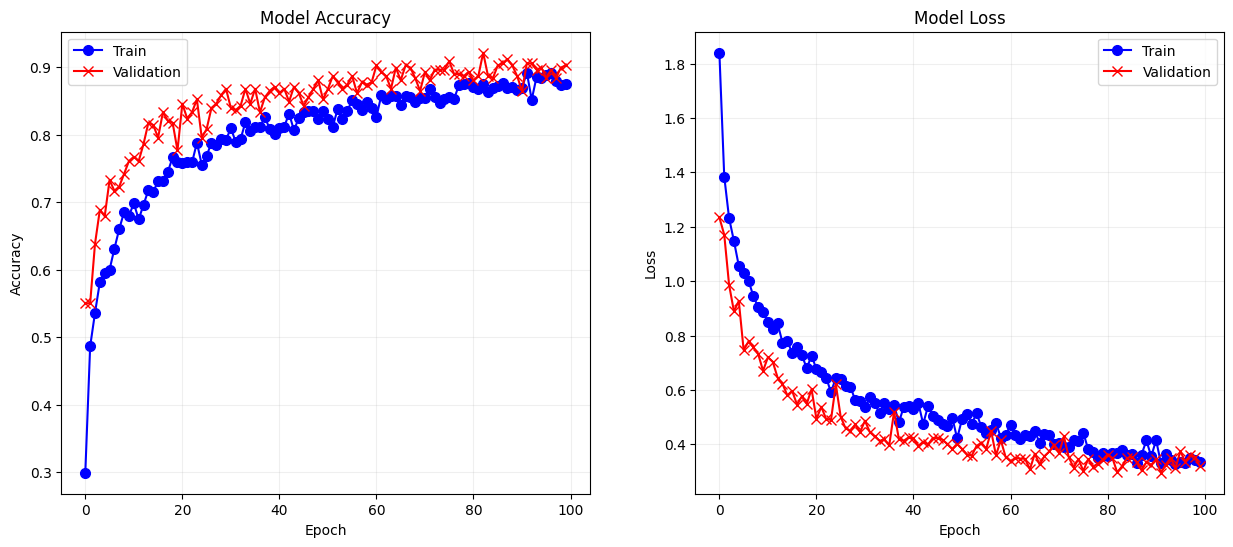

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

# accuracy
ax[0].plot(history.history['accuracy'], marker='o', color='blue', markersize=7)
ax[0].plot(history.history['val_accuracy'], marker='x', color='red', markersize=7)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# loss
ax[1].plot(history.history['loss'], marker='o', color='blue', markersize=7)
ax[1].plot(history.history['val_loss'], marker='x', color='red', markersize=7)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

# **9. Displaying Model Predictions on Test Images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


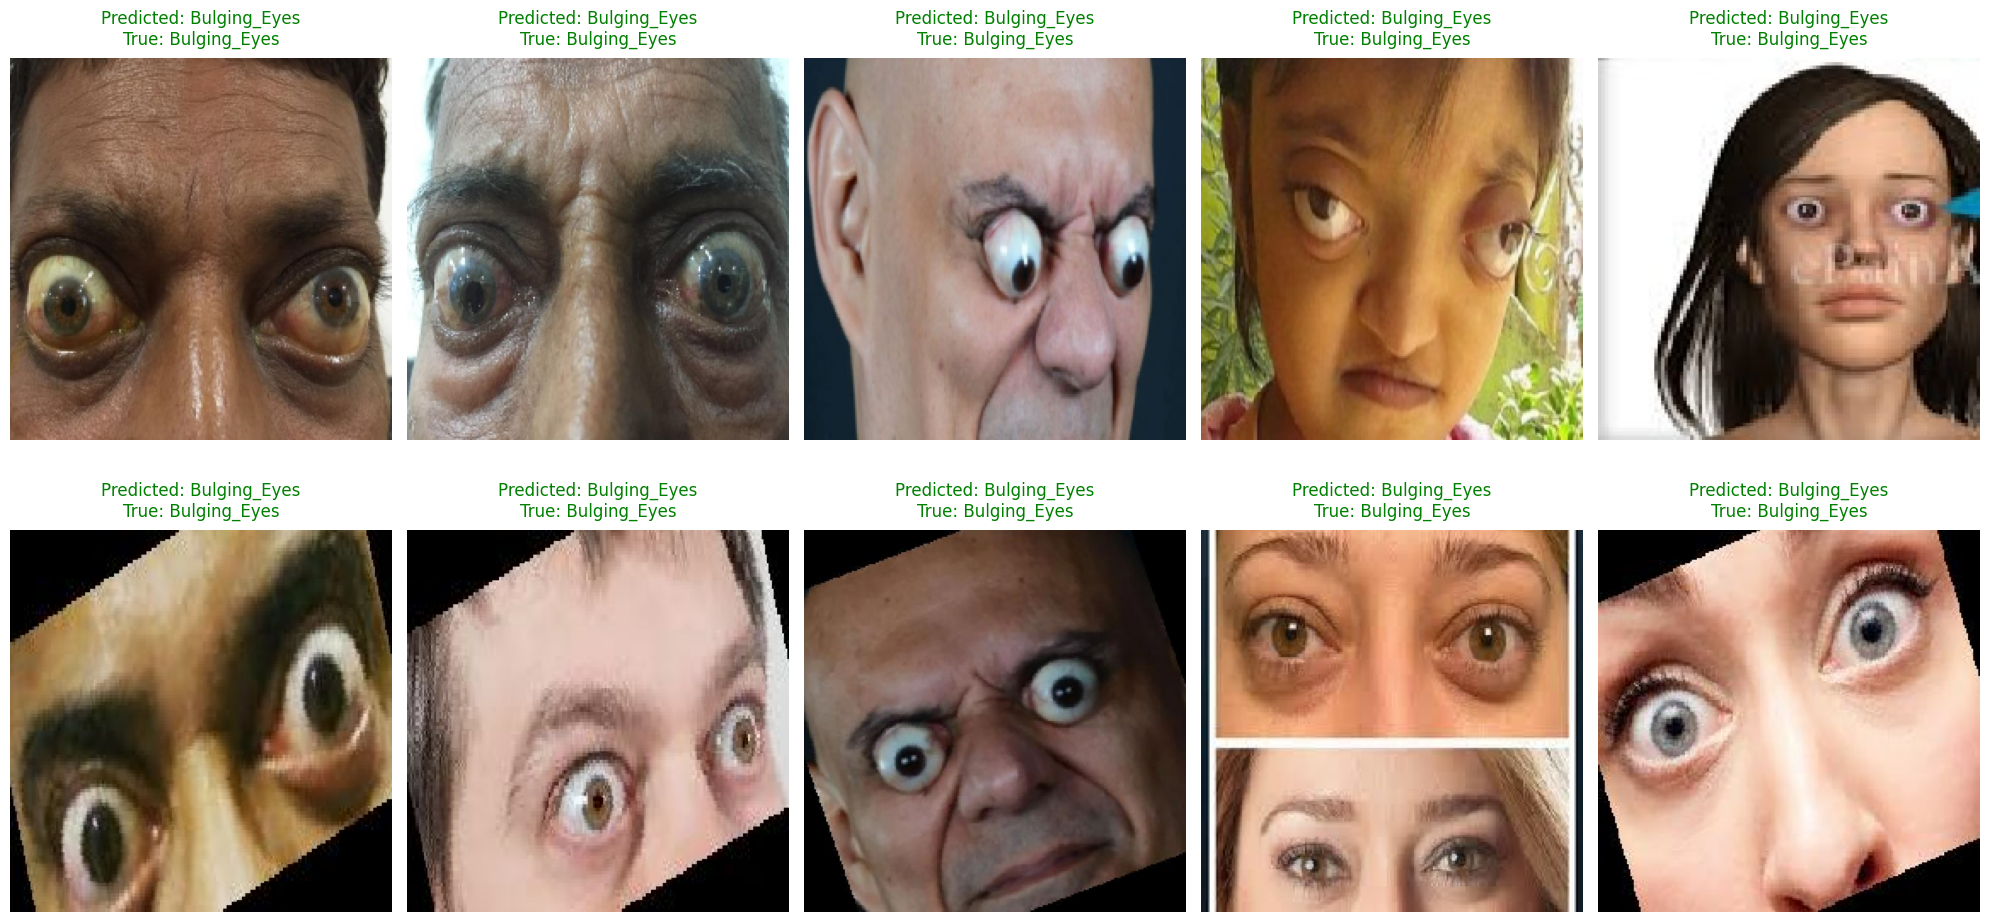

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

def display_images_with_predictions(test_data, model, class_labels, num_images=10):
    # Initialize a counter to keep track of displayed images
    num_displayed = 0

    # Set the font size for the titles
    font_size = 12

    # Set the figure size
    plt.figure(figsize=(20, 10))

    # Iterate through the test data generator
    for images, labels in test_data:
        # Make predictions on the batch of images
        predictions = np.argmax(model.predict(images), axis=1)

        # Iterate through the batch
        for i in range(len(images)):
            if num_displayed >= num_images:
                break

            # Display the image
            ax = plt.subplot(2, 5, num_displayed + 1)
            plt.imshow(images[i])
            plt.axis('off')

            # Get the predicted and true labels
            predicted_label = class_labels[predictions[i]]
            true_label = class_labels[np.argmax(labels[i])]

            # Check if the prediction matches the true label
            if predicted_label == true_label:
                title_color = 'green'
            else:
                title_color = 'red'

            # Set the title with the predicted and true labels
            ax.set_title(f'Predicted: {predicted_label}\nTrue: {true_label}',
                         fontsize=font_size, color=title_color, pad=10)

            # Increment the counter
            num_displayed += 1

        if num_displayed >= num_images:
            break

    # Adjust the layout for better readability
    plt.tight_layout()
    plt.show()

# Example usage (assuming you have your test_data, model, and class_labels defined)
class_labels = list(test_data.class_indices.keys())
display_images_with_predictions(test_data, model, class_labels, num_images=10)

# **11. Save and Download Model .h5**

In [ ]:
import os

# Folder where you want to save the model
model_folder = 'models'
model_filename = 'eyecare.h5'
model_path = os.path.join(model_folder, model_filename)

# Create the folder if it doesn't exist
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Save the model
model.save(model_path)

In [ ]:
from google.colab import files

# Download model .h5
files.download('models/eyecare.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os

# Folder where you want to save the model
model_folder = 'models'
model_filename = 'eyecare.keras'
model_path = os.path.join(model_folder, model_filename)

# Create the folder if it doesn't exist
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Save the model
model.save(model_path)

In [ ]:
from google.colab import files

# Download model .h5
files.download('models/eyecare.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>